<a href="https://colab.research.google.com/github/xingchenzhao/deep_learning_notebooks/blob/master/ImageAugmentation_ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install d2lzh  # installing d2l
!pip install -U --pre mxnet-cu101mkl  # updating mxnet to at least v1.6

In [0]:
%matplotlib inline
import d2lzh as d2l
import mxnet as mx
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import data as gdata, loss as gloss, utils as gutils
import sys
import time

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


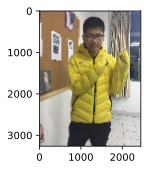

In [0]:
d2l.set_figsize()
img = image.imread('/content/drive/My Drive/Colab Notebooks/d2l-zh/img/sushi.jpg')
d2l.plt.imshow(img.asnumpy())

Create a function to show image

In [0]:
def show_images(imgs, num_rows, num_cols, scale=2):
  figsize = (num_cols * scale, num_rows*scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
  for i in range(num_rows):
    for j in range(num_cols):
      axes[i][j].imshow(imgs[i * num_cols + j].asnumpy())
      axes[i][j].axes.get_xaxis().set_visible(False)
      axes[i][j].axes.get_yaxis().set_visible(False)
  return axes

In [0]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
  Y = [aug(img) for _ in range(num_rows * num_cols)]
  show_images(Y, num_rows, num_cols, scale)

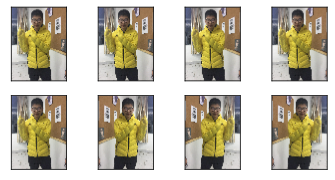

In [0]:
apply(img, gdata.vision.transforms.RandomFlipLeftRight())

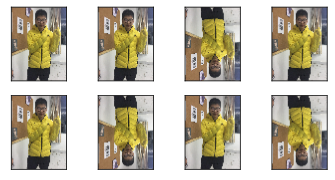

In [0]:
apply(img, gdata.vision.transforms.RandomFlipTopBottom())

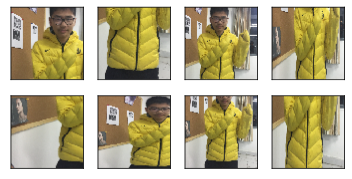

In [0]:
shape_aug = gdata.vision.transforms.RandomResizedCrop(
    (200,200), scale=(0.1, 1), ratio=(0.5,2)
)
apply(img, shape_aug)

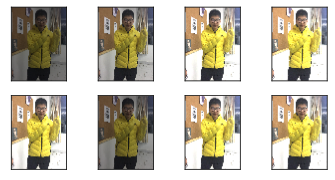

In [0]:
apply(img, gdata.vision.transforms.RandomBrightness(0.5))

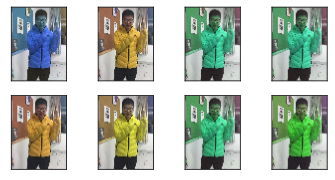

In [0]:
apply(img, gdata.vision.transforms.RandomHue(0.5))

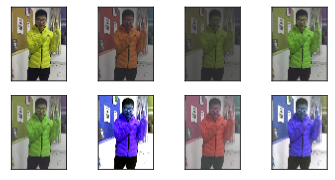

In [0]:
color_aug = gdata.vision.transforms.RandomColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)
apply(img, color_aug)

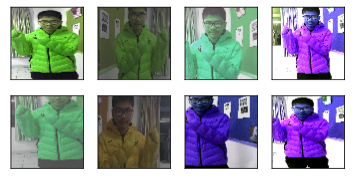

In [0]:
augs = gdata.vision.transforms.Compose([
    gdata.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug
])
apply(img,augs)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f172c653f60>,
      dtype=object)

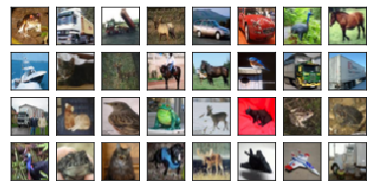

In [0]:
show_images(gdata.vision.CIFAR10(train=True)[0:32][0], 4,8,scale=0.8)

In [0]:
shape_aug_2 = gdata.vision.transforms.RandomResizedCrop(
    (20,20), scale=(0.1, 1), ratio=(0.5,2)
)

img_aug = gdata.vision.transforms.Compose([
  gdata.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug_2,
  gdata.vision.transforms.ToTensor()                                          
])

no_aug = gdata.vision.transforms.Compose([
    gdata.vision.transforms.ToTensor()                                      
])

In [0]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size):
  return gdata.DataLoader(gdata.vision.CIFAR10(train=is_train).transform_first(augs),
                          batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

In [0]:
def try_all_gpus():
  ctxes = []
  try:
    for i in range(16):
      ctx = mx.gpu(i)
      _ = nd.array([0], ctx=ctx)
      ctxes.append(ctx)
  except mx.base.MXNetError:
    pass
  if not ctxes:
    ctxes = [mx.cpu()]
  return ctxes

In [0]:
def _get_batch(batch, ctx):
  features, labels = batch
  if labels.dtype != features.dtype:
    labels = labels.astype(features.dtype)
  return (gutils.split_and_load(features, ctx),
          gutils.split_and_load(labels,ctx), features.shape[0])

In [0]:
def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
  if isinstance(ctx, mx.Context):
    ctx = [ctx]
  acc_sum, n = nd.array([0]),0
  for batch in data_iter:
    features, labels, _ = _get_batch(batch, ctx)
    for X, y in zip(features, labels):
      y = y.astype('float32')
      acc_sum += (net(X).argmax(axis=1) == y).sum().copyto(mx.cpu())
      n += y.size
    acc_sum.wait_to_read()
  return acc_sum.asscalar() / n

In [0]:
def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs):
  print('training on', ctx)
  if isinstance(ctx, mx.Context):
    ctx = [ctx]
  for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n, m, start = 0.0, 0.0, 0, 0, time.time()
    for i, batch in enumerate(train_iter):
      Xs, ys, batch_size = _get_batch(batch,ctx)
      ls = []
      with autograd.record():
        y_hats = [net(X) for X in Xs]
        ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
      for l in ls:
        l.backward()
      trainer.step(batch_size)
      train_l_sum += sum([l.sum().asscalar() for l in ls])
      n += sum([l.size for l in ls])
      train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar() for y_hat, y in zip(y_hats, ys)])
      m+=sum([y.size for y in ys])
    test_acc = evaluate_accuracy(test_iter, net, ctx)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, '
              'time %.1f sec'
              % (epoch + 1, train_l_sum / n, train_acc_sum / m, test_acc,
                 time.time() - start))

In [0]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
  batch_size, ctx, net = 256, try_all_gpus(), d2l.resnet18(10)
  net.initialize(ctx=ctx, init=init.Xavier())
  trainer = gluon.Trainer(net.collect_params(),'adam', {'learning_rate': lr})
  loss = gloss.SoftmaxCrossEntropyLoss()
  train_iter = load_cifar10(True, train_augs, batch_size)
  test_iter = load_cifar10(False, test_augs, batch_size)
  train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs=100)

In [0]:
train_with_data_aug(img_aug, no_aug)

training on [gpu(0)]
epoch 1, loss 2.1747, train acc 0.214, test acc 0.231, time 31.9 sec
epoch 2, loss 1.8935, train acc 0.316, test acc 0.359, time 28.1 sec
epoch 3, loss 1.6736, train acc 0.401, test acc 0.434, time 28.4 sec
epoch 4, loss 1.5089, train acc 0.462, test acc 0.560, time 28.5 sec
epoch 5, loss 1.3945, train acc 0.503, test acc 0.592, time 28.4 sec
epoch 6, loss 1.3221, train acc 0.533, test acc 0.676, time 28.5 sec
epoch 7, loss 1.2512, train acc 0.561, test acc 0.646, time 28.5 sec
epoch 8, loss 1.2022, train acc 0.574, test acc 0.685, time 28.3 sec
epoch 9, loss 1.1626, train acc 0.593, test acc 0.727, time 28.9 sec
epoch 10, loss 1.1316, train acc 0.603, test acc 0.749, time 28.4 sec
epoch 11, loss 1.0998, train acc 0.616, test acc 0.764, time 28.2 sec
epoch 12, loss 1.0770, train acc 0.623, test acc 0.747, time 28.4 sec
epoch 13, loss 1.0483, train acc 0.634, test acc 0.774, time 28.3 sec
epoch 14, loss 1.0218, train acc 0.645, test acc 0.772, time 28.4 sec
epoch 15